In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load data
clean_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\mixed_filtered.csv", delimiter=",")

# Train-test split: cellulose samples as test set
train_data = clean_data[clean_data['fuel_type'] != 'digestate_pe']
test_data = clean_data[clean_data['fuel_type'] == 'digestate_pe']

# Extract features and target
X_train = train_data.drop(columns=['Unnamed: 0','sample', 'devol_yield'])
noise = np.random.uniform(-3, 3, size=len(X_train))
y_train = train_data['devol_yield'] + noise
X_test = test_data.drop(columns=['Unnamed: 0','sample', 'devol_yield'])
y_test = test_data['devol_yield']

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Initialize scaler
scaler = StandardScaler()

# Scale only numerical columns
X_train_scaled_num = pd.DataFrame(
    scaler.fit_transform(X_train[numerical_cols]),
    columns=numerical_cols,
    index=X_train.index
)

X_test_scaled_num = pd.DataFrame(
    scaler.transform(X_test[numerical_cols]),
    columns=numerical_cols,
    index=X_test.index
)

# Concatenate scaled numerical features with unscaled categorical features
X_train_final = pd.concat([X_train_scaled_num, X_train[['fuel_type', 'fuel_category']]], axis=1)
X_test_final = pd.concat([X_test_scaled_num, X_test[['fuel_type', 'fuel_category']]], axis=1)

X_train_final['fuel_type'] = X_train_final['fuel_type'].astype('category')
X_train_final['fuel_category'] = X_train_final['fuel_category'].astype('category')
X_test_final['fuel_type'] = X_test_final['fuel_type'].astype('category')
X_test_final['fuel_category'] = X_test_final['fuel_category'].astype('category')

# LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Hyperparameter search space
param_dist = {
    'n_estimators': [200, 500, 700],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [5, 10, -1],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 1.0],
    'reg_lambda': [0.1, 1.0, 1.5]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train_final, y_train)

# Best model
best_lgb = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)

# Evaluate on cellulose test set
y_pred = best_lgb.predict(X_test_final)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluation on Cellulose Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

joblib.dump(best_lgb, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_lgb_model_plastic_test.pkl")
joblib.dump(scaler, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\scaler_lgb_plastic.pkl")


print("\nLightGBM model and preprocessing pipeline saved.")


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 17
[LightGBM] [Info] Start training from score 49.468615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Text(0, 0.5, 'Predicted devol_yield')

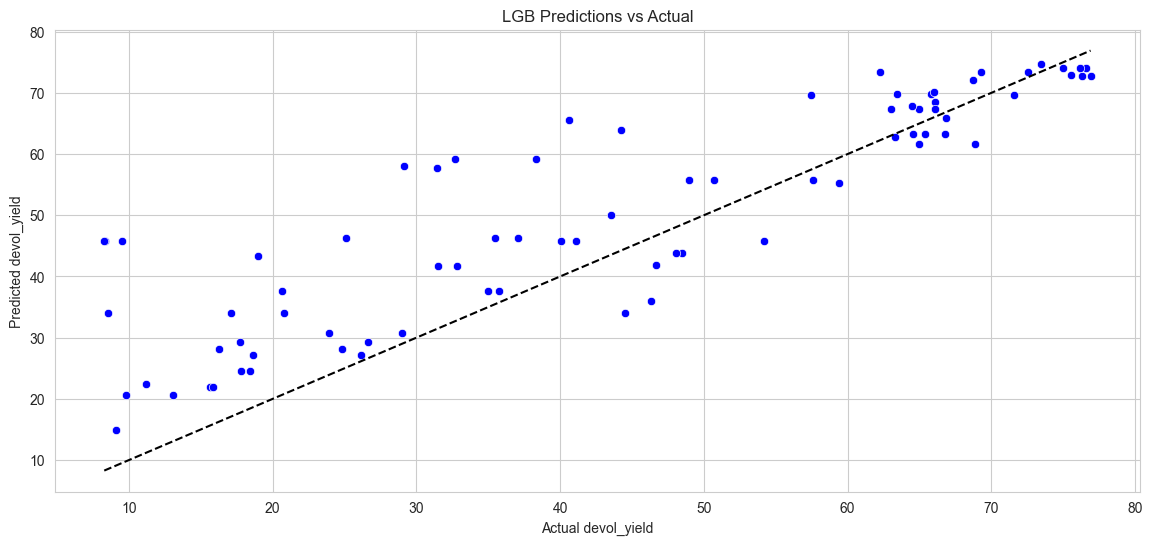

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("LGB Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

(array([ 4., 17., 14., 18., 11.,  2.,  3.,  5.,  1.,  3.]),
 array([-10.4962385 ,  -5.69149144,  -0.88674438,   3.91800267,
          8.72274973,  13.52749679,  18.33224385,  23.13699091,
         27.94173797,  32.74648502,  37.55123208]),
 <BarContainer object of 10 artists>)

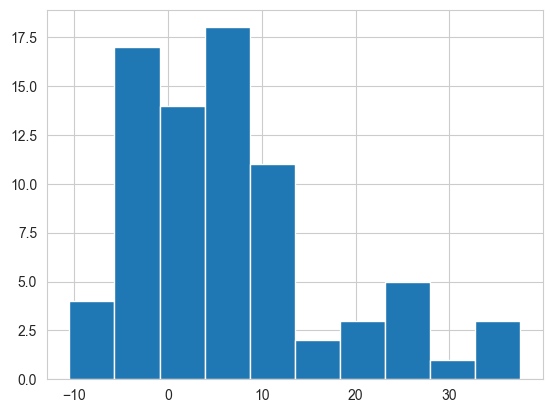

In [10]:
plt.hist(y_pred-y_test)